<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plan-of-Action" data-toc-modified-id="Plan-of-Action-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plan of Action</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Exploring-Variables,-Distributions-and-Correlations" data-toc-modified-id="Exploring-Variables,-Distributions-and-Correlations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploring Variables, Distributions and Correlations</a></span></li><li><span><a href="#Preparing-Data-for-Machine-Learning" data-toc-modified-id="Preparing-Data-for-Machine-Learning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preparing Data for Machine Learning</a></span></li><li><span><a href="#Modelling-&amp;-Evaluation" data-toc-modified-id="Modelling-&amp;-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelling &amp; Evaluation</a></span></li><li><span><a href="#Top-Feature-Identification" data-toc-modified-id="Top-Feature-Identification-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Top Feature Identification</a></span></li><li><span><a href="#Test-Set-Predictions-and-Error-Measurement" data-toc-modified-id="Test-Set-Predictions-and-Error-Measurement-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Test Set Predictions and Error Measurement</a></span></li><li><span><a href="#Exporting-a-Dataset-of-Feature-Importances" data-toc-modified-id="Exporting-a-Dataset-of-Feature-Importances-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Exporting a Dataset of Feature Importances</a></span></li></ul></div>

# Plan of Action

We will run through a brief round of machine learning to help us identify important variables for our analysis. The intention here is not to optimise and tune our algorithms to reach the minimal possible error or run through an elaborate feature engineering process. Rather, we will run apply a basic ML pipeline and cross-validation on our data and using a variety of models with default parameters. Then we will do a quick grid search on the best performing model, before determining the feature importances that we can take with us into the analysis. We will apply a log transformation to any numeric valriables whose skew values is greater than or equal to 1. 

Overall we're looking for a rough sense of the most important features.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

pd.set_option("display.max_columns",999)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

# Exploring Variables, Distributions and Correlations

In [4]:
df = pd.read_csv('datasets/processed/zomato-cape-town-final.csv', encoding='utf-8-sig')
df.head()

,name,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,cuisines,cuisine_count,has_online_delivery,has_table_booking,places,place_type,locality,region,city,latitude,longitude,municipality,ward_id,ward_num,ward_pop,ward_area,geometry,African,American,Arabian,Asian,BBQ,Bakery,Bar Food,Belgian,Beverages,Brazilian,British,Burger,Cafe,Cafe Food,Cape Malay,Caribbean,Chinese,Coffee and Tea,Contemporary,Continental,Cuban,Deli,Desserts,Drinks Only,Durban,Egyptian,Ethiopian,European,Fast Food,Finger Food,Fish and Chips,French,Frozen Yogurt,Fusion,German,Greek,Grill,Healthy Food,Ice Cream,Indian,International,Irish,Italian,Japanese,Juices,Korean,Latin American,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,Pakistani,Patisserie,Pizza,Portuguese,Pub Food,Salad,Sandwich,Seafood,South African,Spanish,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese
0,The Potluck Club,4.9,Excellent,406,600,4,"European, Contemporary",2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,Cape Town,-33.927589,18.457068,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,La Colombe,4.9,Excellent,146,645,4,"French, Asian",2,0,0,None,None,Constantia,Southern Suburbs,Cape Town,-34.012639,18.402608,City of Cape Town Metropolitan Municipality,19100062,62,16615,44.110018,POLYGON ((18.45126800000003 -33.96372699899996...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Moro Gelato,4.8,Excellent,72,80,1,"Desserts, Ice Cream",2,0,0,None,None,CBD,City Bowl,Cape Town,-33.924108,18.417317,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Unframed Ice Cream,4.7,Excellent,104,40,1,Ice Cream,1,0,0,None,None,Gardens,City Bowl,Cape Town,-33.928691,18.412097,City of Cape Town Metropolitan Municipality,19100077,77,17022,21.884528,POLYGON ((18.42162859000007 -33.91447890999996...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Test Kitchen,4.7,Excellent,242,2800,4,"Continental, European",2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,Cape Town,-33.927373,18.456906,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
df.describe()

,aggregate_rating,votes,average_cost_for_two,price_range,cuisine_count,has_online_delivery,has_table_booking,latitude,longitude,ward_id,ward_num,ward_pop,ward_area,African,American,Arabian,Asian,BBQ,Bakery,Bar Food,Belgian,Beverages,Brazilian,British,Burger,Cafe,Cafe Food,Cape Malay,Caribbean,Chinese,Coffee and Tea,Contemporary,Continental,Cuban,Deli,Desserts,Drinks Only,Durban,Egyptian,Ethiopian,European,Fast Food,Finger Food,Fish and Chips,French,Frozen Yogurt,Fusion,German,Greek,Grill,Healthy Food,Ice Cream,Indian,International,Irish,Italian,Japanese,Juices,Korean,Latin American,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,Pakistani,Patisserie,Pizza,Portuguese,Pub Food,Salad,Sandwich,Seafood,South African,Spanish,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese
count,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.0,1354.000000,1354.000000,1354.000000,1.354000e+03,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000,1354.000000
mean,3.079690,50.891433,243.072378,2.751846,1.925406,0.0,0.002954,-33.935923,18.586136,1.734089e+07,37.388479,13617.813885,34.217776,0.042097,0.027326,0.000739,0.019202,0.000739,0.076809,0.001477,0.001477,0.028804,0.001477,0.002954,0.125554,0.211226,0.000739,0.011078,0.002216,0.011078,0.004431,0.052437,0.016248,0.003693,0.022157,0.120384,0.125554,0.005170,0.000739,0.000739,0.059823,0.092319,0.053914,0.010340,0.019941,0.002216,0.000739,0.005170,0.002216,0.106352,0.036928,0.036928,0.022895,0.012555,0.001477,0.052437,0.014032,0.008863,0.001477,0.002216,0.003693,0.053176,0.021418,0.002954,0.000739,0.000739,0.001477,0.006647,0.084934,0.014771,0.000739,0.000739,0.002954,0.079025,0.060561,0.002216,0.047267,0.005170,0.039143,0.021418,0.001477,0.001477,0.009601,0.000739,0.001477,0.001477
std,0.959525,76.728455,175.483698,1.018172,1.300255,0.0,0.054292,0.108031,0.249852,3.542558e+06,30.414963,4875.618578,49.336580,0.200886,0.163093,0.027176,0.137286,0.027176,0.266387,0.038419,0.038419,0.167316,0.038419,0.054292,0.331468,0.408329,0.027176,0.104707,0.047036,0.104707,0.066445,0.222989,0.126475,0.060678,0.147247,0.325530,0.331468,0.071742,0.027176,0.027176,0.237246,0.289583,0.225932,0.101195,0.139849,0.047036,0.027176,0.071742,0.047036,0.308401,0.188654,0.188654,0.149624,0.111386,0.038419,0.222989,0.117668,0.093758,0.038419,0.047036,0.060678,0.224467,0.144827,0.054292,0.027176,0.027176,0.038419,0.081288,0.278886,0.120680,0.027176,0.027176,0.054292,0.269878,0.238612,0.047036,0.212289,0.071742,0.194007,0.144827,0.038419,0.038419,0.097550,0.027176,0.038419,0.038419
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,-34.434840,18.344877,1.010501e+07,1.000000,3367.000000,0.709819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [6]:
def get_cuisine_cols():
    cols = ["name", "aggregate_rating", "rating_text", "votes", "average_cost_for_two", "price_range", "cuisines", "cuisine_count", "places", "locality", "region", "city", "latitude", "longitude", "has_online_delivery", "has_table_booking", "top_bottom", "place_type", "municipality", "ward_id", "ward_num", "ward_pop", "ward_area", "geometry"]
    '''Returns the column names of all the cuisine type column, not including the cuisine_count column'''
    cuisine_cols = [col for col in df.columns.tolist() if col not in cols]
    return cuisine_cols  

cuisine_cols = get_cuisine_cols()

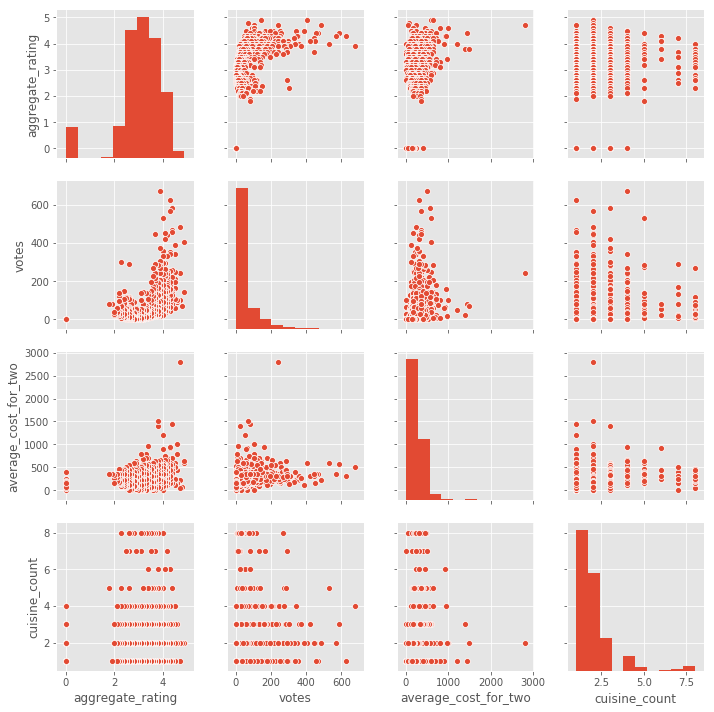

In [7]:
sns.pairplot(df, vars=["aggregate_rating", "votes", "average_cost_for_two", "cuisine_count"])

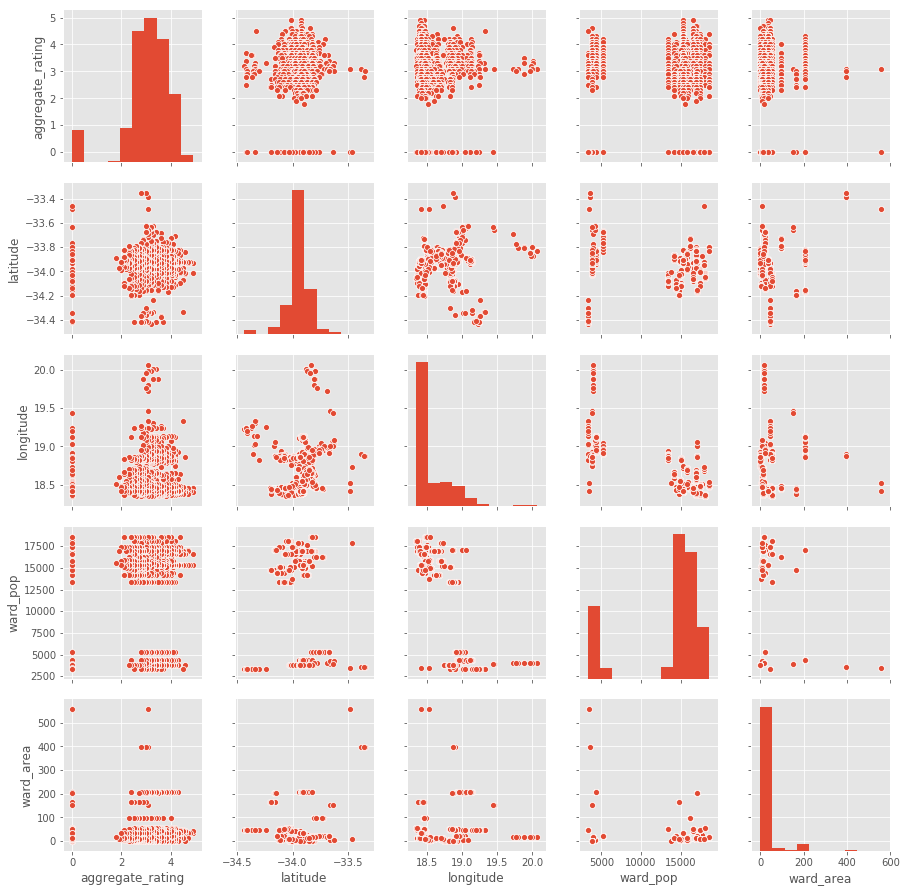

In [8]:
sns.pairplot(df, vars=["aggregate_rating", "latitude", "longitude", "ward_pop", "ward_area"])

In [9]:
df.corr()["aggregate_rating"].sort_values(ascending=False)[:10]

aggregate_rating        1.000000
votes                   0.445820
average_cost_for_two    0.309734
price_range             0.303954
European                0.136510
Contemporary            0.122082
cuisine_count           0.118628
Mediterranean           0.110024
French                  0.095002
International           0.081914
Name: aggregate_rating, dtype: float64

In [10]:
df.corr()["aggregate_rating"].sort_values(ascending=False)[-10:]

Street Food           -0.055378
Drinks Only           -0.069825
ward_pop              -0.076550
Bakery                -0.077169
Ice Cream             -0.077922
ward_id               -0.078317
ward_num              -0.096177
Fast Food             -0.104167
Desserts              -0.135559
has_online_delivery         NaN
Name: aggregate_rating, dtype: float64

# Preparing Data for Machine Learning

Let's see if there are any missing values we need to handle

In [11]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

We're going to remove any rows whose rating or average cost is 0.

In [12]:
df[df.aggregate_rating == 0].shape[0]

81

In [13]:
df[df.average_cost_for_two == 0].shape[0]

17

In [14]:
print(df.shape[0])
df = df[(df.aggregate_rating != 0.0) & (df.average_cost_for_two != 0)]
print(df.shape[0])

1354
1258


In [15]:
df.head()

,name,aggregate_rating,rating_text,votes,average_cost_for_two,price_range,cuisines,cuisine_count,has_online_delivery,has_table_booking,places,place_type,locality,region,city,latitude,longitude,municipality,ward_id,ward_num,ward_pop,ward_area,geometry,African,American,Arabian,Asian,BBQ,Bakery,Bar Food,Belgian,Beverages,Brazilian,British,Burger,Cafe,Cafe Food,Cape Malay,Caribbean,Chinese,Coffee and Tea,Contemporary,Continental,Cuban,Deli,Desserts,Drinks Only,Durban,Egyptian,Ethiopian,European,Fast Food,Finger Food,Fish and Chips,French,Frozen Yogurt,Fusion,German,Greek,Grill,Healthy Food,Ice Cream,Indian,International,Irish,Italian,Japanese,Juices,Korean,Latin American,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,Pakistani,Patisserie,Pizza,Portuguese,Pub Food,Salad,Sandwich,Seafood,South African,Spanish,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese
0,The Potluck Club,4.9,Excellent,406,600,4,"European, Contemporary",2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,Cape Town,-33.927589,18.457068,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,La Colombe,4.9,Excellent,146,645,4,"French, Asian",2,0,0,None,None,Constantia,Southern Suburbs,Cape Town,-34.012639,18.402608,City of Cape Town Metropolitan Municipality,19100062,62,16615,44.110018,POLYGON ((18.45126800000003 -33.96372699899996...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Moro Gelato,4.8,Excellent,72,80,1,"Desserts, Ice Cream",2,0,0,None,None,CBD,City Bowl,Cape Town,-33.924108,18.417317,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Unframed Ice Cream,4.7,Excellent,104,40,1,Ice Cream,1,0,0,None,None,Gardens,City Bowl,Cape Town,-33.928691,18.412097,City of Cape Town Metropolitan Municipality,19100077,77,17022,21.884528,POLYGON ((18.42162859000007 -33.91447890999996...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Test Kitchen,4.7,Excellent,242,2800,4,"Continental, European",2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,Cape Town,-33.927373,18.456906,City of Cape Town Metropolitan Municipality,19100015,15,15321,35.375211,POLYGON ((18.86541799800005 -34.04616599799994...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
df = df.drop(["name", "rating_text", "cuisines", "city", "municipality", "ward_id", "geometry"], axis=1)
df.head()

,aggregate_rating,votes,average_cost_for_two,price_range,cuisine_count,has_online_delivery,has_table_booking,places,place_type,locality,region,latitude,longitude,ward_num,ward_pop,ward_area,African,American,Arabian,Asian,BBQ,Bakery,Bar Food,Belgian,Beverages,Brazilian,British,Burger,Cafe,Cafe Food,Cape Malay,Caribbean,Chinese,Coffee and Tea,Contemporary,Continental,Cuban,Deli,Desserts,Drinks Only,Durban,Egyptian,Ethiopian,European,Fast Food,Finger Food,Fish and Chips,French,Frozen Yogurt,Fusion,German,Greek,Grill,Healthy Food,Ice Cream,Indian,International,Irish,Italian,Japanese,Juices,Korean,Latin American,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,Pakistani,Patisserie,Pizza,Portuguese,Pub Food,Salad,Sandwich,Seafood,South African,Spanish,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese
0,4.9,406,600,4,2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,-33.927589,18.457068,15,15321,35.375211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.9,146,645,4,2,0,0,None,None,Constantia,Southern Suburbs,-34.012639,18.402608,62,16615,44.110018,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.8,72,80,1,2,0,0,None,None,CBD,City Bowl,-33.924108,18.417317,15,15321,35.375211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.7,104,40,1,1,0,0,None,None,Gardens,City Bowl,-33.928691,18.412097,77,17022,21.884528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.7,242,2800,4,2,0,0,Old Biscuit Mill,Mall,Woodstock,City Bowl,-33.927373,18.456906,15,15321,35.375211,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We'll convert some numerical/ordinal/boolean fields to categorical. Also since the cuisine-based columns have already been onoe-hot encoded, we covert these to integers. Later we'll need to prevent these from being further ncoded in our ML pipeline.

In [17]:
df.select_dtypes(include=[np.number]).columns

Index(['aggregate_rating', 'votes', 'average_cost_for_two', 'price_range',
       'cuisine_count', 'has_online_delivery', 'has_table_booking', 'latitude',
       'longitude', 'ward_num', 'ward_pop', 'ward_area', 'African', 'American',
       'Arabian', 'Asian', 'BBQ', 'Bakery', 'Bar Food', 'Belgian', 'Beverages',
       'Brazilian', 'British', 'Burger', 'Cafe', 'Cafe Food', 'Cape Malay',
       'Caribbean', 'Chinese', 'Coffee and Tea', 'Contemporary', 'Continental',
       'Cuban', 'Deli', 'Desserts', 'Drinks Only', 'Durban', 'Egyptian',
       'Ethiopian', 'European', 'Fast Food', 'Finger Food', 'Fish and Chips',
       'French', 'Frozen Yogurt', 'Fusion', 'German', 'Greek', 'Grill',
       'Healthy Food', 'Ice Cream', 'Indian', 'International', 'Irish',
       'Italian', 'Japanese', 'Juices', 'Korean', 'Latin American', 'Lebanese',
       'Mediterranean', 'Mexican', 'Middle Eastern', 'Modern European',
       'Moroccan', 'Pakistani', 'Patisserie', 'Pizza', 'Portuguese',
       'Pub F

In [18]:
NumStr = ["price_range", "cuisine_count", "has_online_delivery", "has_table_booking", "ward_num"]
for col in NumStr:
    df[col]=df[col].astype(str)
    
for col in cuisine_cols:
    df[col]=df[col].astype(int)

In [19]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["price_range"] = lab.fit_transform(X["price_range"])
        X["cuisine_count"] = lab.fit_transform(X["cuisine_count"])
        X["has_online_delivery"] = lab.fit_transform(X["has_online_delivery"])
        X["has_table_booking"] = lab.fit_transform(X["has_table_booking"])
        X["ward_num"] = lab.fit_transform(X["ward_num"])
        return X

We'll check numeric columns for their skew and if it's absolute value is greater than or equal 1, we'll perform a log transform on them. We'll then perform one-hot encoding on the categorical variables. As the cuisine columns have already been encoded, we'll skip these columns. We don't want latitude and longitude columns being log transformed either, especially latitude which are negative numbers. This would result in them being `nan` due to the infinities created by log transforming a negative number. ML pipelines dont like `inf` or `nan`.

In [20]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        # cuisine cols are already in dummy format, so we dont want them to be 'dummied' again.
        cols = [col for col in X.columns if col not in cuisine_cols]
        # we dont want latitiude and longitude being checked for skew either - latitude will become NaN due to imfinities from log computation
        cols = [col for col in cols if col not in ["latitude", "longitude"]]
        X_numeric = X[cols]
        X_numeric=X_numeric.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [21]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

We're splitting the data set into a training and test set. Stricly speaking, this isnt so neccessary in this case because we arent trying to minimise our prediction error, however it will be useful to see what error we do get from a very basic ML process. The split isn't stratified, this means there is likely some sampling bias. If this was to be a full-on ML project, I would ensure the sample distrubutions of the training and test set are similar. 

In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=1)
full = pd.concat([train, test], ignore_index=True)

In [23]:
data_pipe = pipe.fit_transform(full.copy())
data_pipe.drop("aggregate_rating", axis=1, inplace=True)
print(data_pipe.shape)
data_pipe.head()

(1258, 290)


,votes,average_cost_for_two,price_range,cuisine_count,has_online_delivery,has_table_booking,latitude,longitude,ward_num,ward_pop,ward_area,African,American,Arabian,Asian,BBQ,Bakery,Bar Food,Belgian,Beverages,Brazilian,British,Burger,Cafe,Cafe Food,Cape Malay,Caribbean,Chinese,Coffee and Tea,Contemporary,Continental,Cuban,Deli,Desserts,Drinks Only,Durban,Egyptian,Ethiopian,European,Fast Food,Finger Food,Fish and Chips,French,Frozen Yogurt,Fusion,German,Greek,Grill,Healthy Food,Ice Cream,Indian,International,Irish,Italian,Japanese,Juices,Korean,Latin American,Lebanese,Mediterranean,Mexican,Middle Eastern,Modern European,Moroccan,Pakistani,Patisserie,Pizza,Portuguese,Pub Food,Salad,Sandwich,Seafood,South African,Spanish,Steak,Street Food,Sushi,Tapas,Tea,Tex-Mex,Thai,Turkish,Vegetarian,Vietnamese,places_12 Apostles Hotel & Spa,places_African Pride 15 on Orange Hotel,places_Alphen 5 Star Boutique Hotel,places_Anura,places_Asara Wine Estate,places_Ashley Cooper House,places_Avondale Wines,places_Babylonstoren Wine Estate,places_Bayside Mall,places_Bayside on Fish Hoek Beach,places_Beau Constantia Wine Estate,places_Beyerskloof Wine Estate,places_Bloemendal Wine Farm,places_Blue Route Mall,places_Boschendal Estate,places_Canal Walk Mall,places_Cape Quarter Lifestyle Center,places_Capegate Shopping Center,places_Cavendish Square,places_Centre Court,places_Chapmans Peak Beach Hotel,places_Cobble Walk Center,places_Colosseum Building,places_Constantia Village,places_De Wet Square,places_Dean Street Arcade,places_Delaire Graff Estate,places_Double Tree by Hilton,places_Dunkley Square,places_Eden On The Bay Centre,places_Eikestad Mall,places_Erinvale Estate Hotel & Spa,places_Fairbridge Mall,places_Flamingo Square Centre,places_Fountain Square,places_Gatesville Center,places_Glenelly Estate,places_Glengarry Shopping Center,places_Graanendal Shopping Center,places_Grandwest Casino,places_Groot Constantia Wine Estate,places_Harfield Village,places_Hidden Valley Wine Estate,places_Hilton Cape Town,places_Horizon Bay,places_Hotel Cape Grace,places_Jordan Wine Farm,places_Kenilworth Center,places_Kromboom Garden Center,places_L'Ormarins Wine Estate,places_Lagoon Beach Hotel,places_Lakeside Center,places_Lanzerac Wine Estate,places_Longridge Wine Estate,places_Mainstream Shopping Centre,places_Mount Nelson Hotel,places_N1 City Mall,places_NH The Lord Charles Hotel,places_Nederburg Wines,places_Nitida Wine Farm,places_None,places_Okavango Crossing Shopping Centre,places_Old Biscuit Mill,places_One and Only Hotel,places_Paddock Shopping Centre,places_Palm Grove Center,places_Parklands Center,places_Parklands Junction,places_Parow Centre,places_Pearl Mountain Wine Estate,places_Piazza Da Luz,places_Plattekloof Center,places_Plattekloof Village,places_Portico Building,places_Portside Building,places_Radisson Blu Hotel & Residence,places_Radisson Blu Le Vendome Hotel,places_Rawoot Square,places_Ridgeback Wine Farm,places_Riverside Mall,places_Sandown Retail Crossing Center,places_Seaside Village,places_Somerset Mall,places_Southern Sun Newlands,places_Spice Route Farm,places_Spier Wine Estate,places_St Peters Square,places_Steenberg Hotel,places_Steenberg Village,places_Surfers Corner,places_Taj Cape Town,places_The Bay Hotel,places_The Cellars-Hohenhort,places_The Cullinan,places_The Devon Valley Hotel,places_The Marine Hotel,places_The Promenade,places_The Sanctuary Shopping Centre,places_The Silo Hotel,places_The Table Bay Hotel,places_The Village Lodge,places_The Westin,places_Tokara Wine Estate,places_Two Oceans Beach,places_Tyger Manor,places_Tygervalley Shopping Centre,places_V & A Foodmarket,places_Vangate Mall,places_Vergelegen,places_Victoria Wharf,places_Village Square,places_Vineyard Hotel & Spa,places_Vredenheim Wine Estate,places_Waterstone Village,places_Wembley Square,places_Westcoast Village,places_Willowbridge Lifestyle Centre,places_Yard,places_Zevenwacht Mall,place_type_Apartments,place_type_Beach,place_type_Business,place_type_C

We'll apply the `RobustScaler` as there are some outliers. 

In [24]:
scaler = RobustScaler()

In [25]:
n_train = train.shape[0]

X_train = data_pipe[:n_train]
y_train = train.aggregate_rating

X_test = data_pipe[n_train:]
y_test = test.aggregate_rating

X_train_scaled = scaler.fit(X_train).transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelling & Evaluation

In [26]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [27]:
models = [LinearRegression(), Ridge(), Lasso(alpha=0.01,max_iter=10000), RandomForestRegressor(), GradientBoostingRegressor(), SVR(), LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000), SGDRegressor(max_iter=1000,tol=1e-3), BayesianRidge(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(), XGBRegressor()]

In [28]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela", "SGD", "Bay", "Ker", "Extra", "Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X_train_scaled, y_train)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))

LR: 2817066402.622045, 2701801294.2581
Ridge: 0.401962, 0.0312
Lasso: 0.423610, 0.0201
RF: 0.408463, 0.0262
GBR: 0.380175, 0.0298
SVR: 0.420221, 0.0253
LinSVR: 0.432063, 0.0323
Ela: 0.397684, 0.0291
SGD: 0.430141, 0.0242
Bay: 0.395907, 0.0311
Ker: 0.402038, 0.0276
Extra: 0.407035, 0.0355
Xgb: 0.377275, 0.0285


`XGBoost` seems to be the best performing algorithm with very basic parameters, so let's perform a grid search to fine-tune it slightly. 

In [31]:
class grid():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
        return grid_search.best_params_

In [32]:
param_grid={'booster':['gbtree', 'gblinear', 'dart'], 'max_depth':[2, 3, 4], 'learning_rate':[0.05, 0.1, 0.3], 'n_estimators':[100, 500, 1000], 'n_jobs':[-1]}
best_params_ = grid(XGBRegressor()).grid_get(X_train_scaled, y_train, param_grid)

{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'n_jobs': -1} 0.3726814700738444
                                               params  mean_test_score  \
0   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.409624   
1   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.381886   
2   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.379123   
3   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.390955   
4   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.372681   
5   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.373345   
6   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.383610   
7   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.374839   
8   {'booster': 'gbtree', 'learning_rate': 0.05, '...         0.381011   
9   {'booster': 'gbtree', 'learning_rate': 0.1, 'm...         0.391193   
10  {'booster': 'gbtree', 'learning_rate': 0.1, 'm...         0.377959 

# Top Feature Identification

We'll use the best parameters obtained from our grid search to identify the top features.

In [33]:
xgb = XGBRegressor(**best_params_)
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
FI_xgb = pd.DataFrame({"Feature Importance" : xgb.feature_importances_}, index=data_pipe.columns).sort_values("Feature Importance", ascending=False)

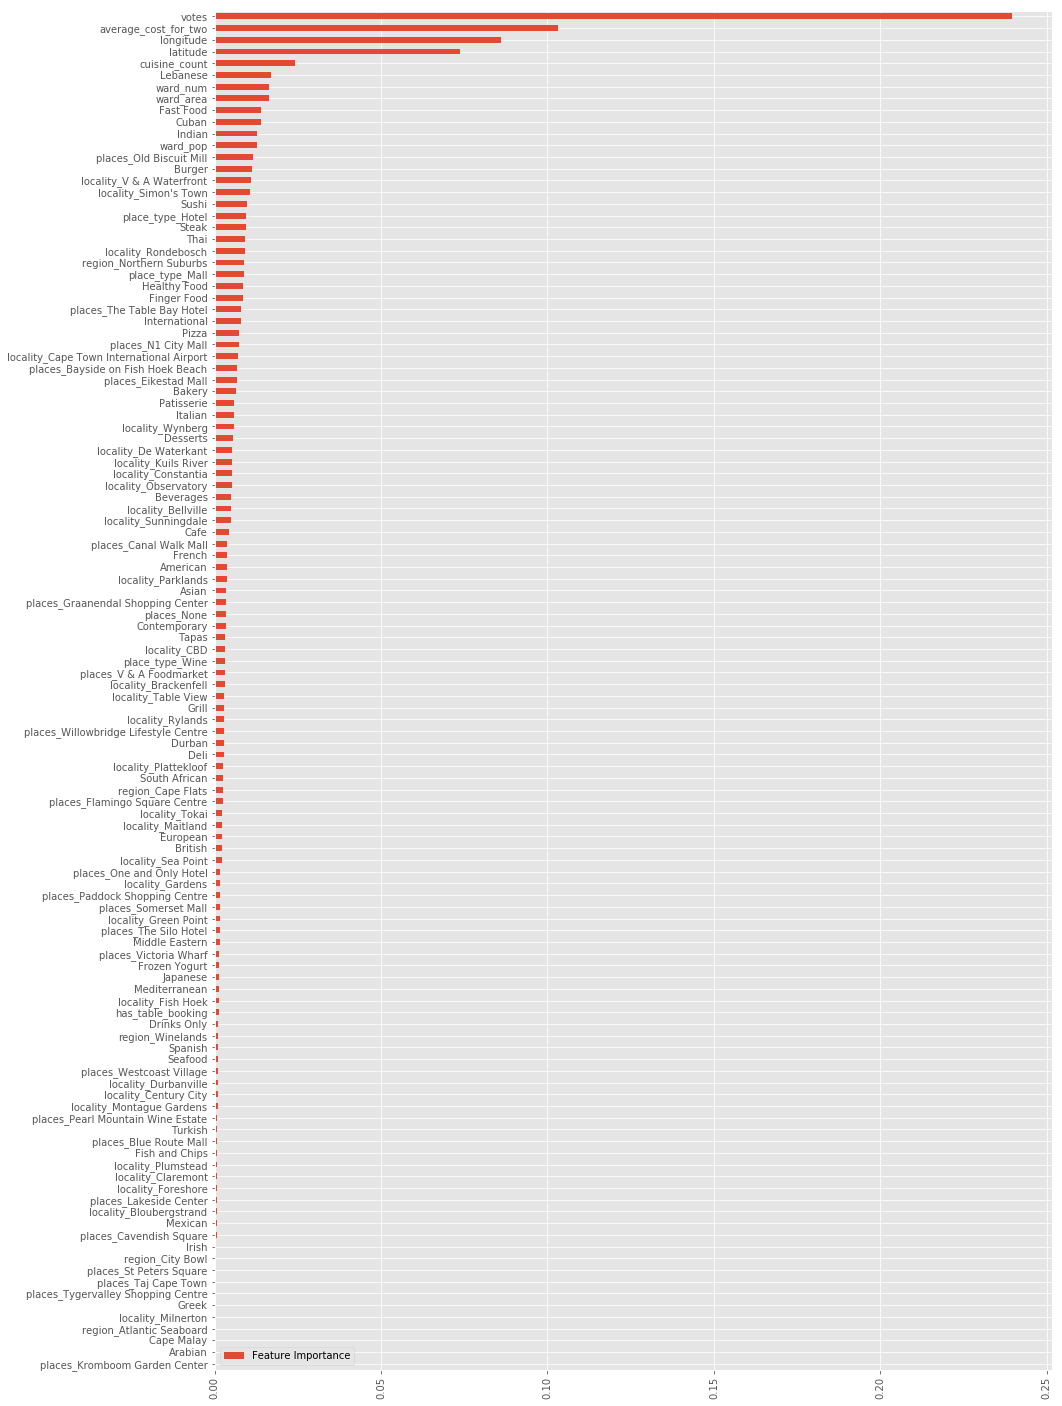

In [35]:
FI_xgb[FI_xgb["Feature Importance"] != 0].sort_values("Feature Importance").plot(kind="barh", figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

I'm not convinced that we've learnt a lot from this exercise, but we'll see if these top features carry some meaning in our analysis. Votes and average cost are no suprise. 

# Test Set Predictions and Error Measurement

For the fun of it, let's see what error we get on our test set predictions using our best performing regressor. 

In [37]:
y_pred = xgb.predict(X_test_scaled)

In [39]:
np.sqrt(mean_squared_error(y_test, y_pred))

0.35179232973346936

Given that our ratings run fromo 0 to 5, we'd like to do better than this if we were submitting our predictions to a competition or building a real-time model, but for our current purposes, this is ok.

# Exporting a Dataset of Feature Importances

In [42]:
FI_xgb.to_csv("datasets/processed/feature_importances.csv")